Best Hyperparameters:  {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Test Accuracy: 98.70%
Classification Report:
              precision    recall  f1-score   support

       Risky       0.99      0.99      0.99      3512
    Moderate       0.97      0.98      0.98      1993
        Safe       0.99      0.98      0.99      2030

    accuracy                           0.99      7535
   macro avg       0.99      0.99      0.99      7535
weighted avg       0.99      0.99      0.99      7535



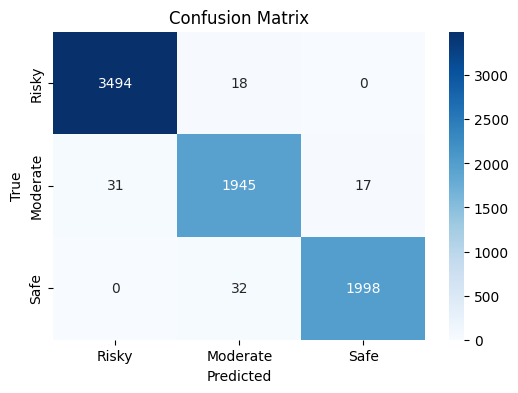

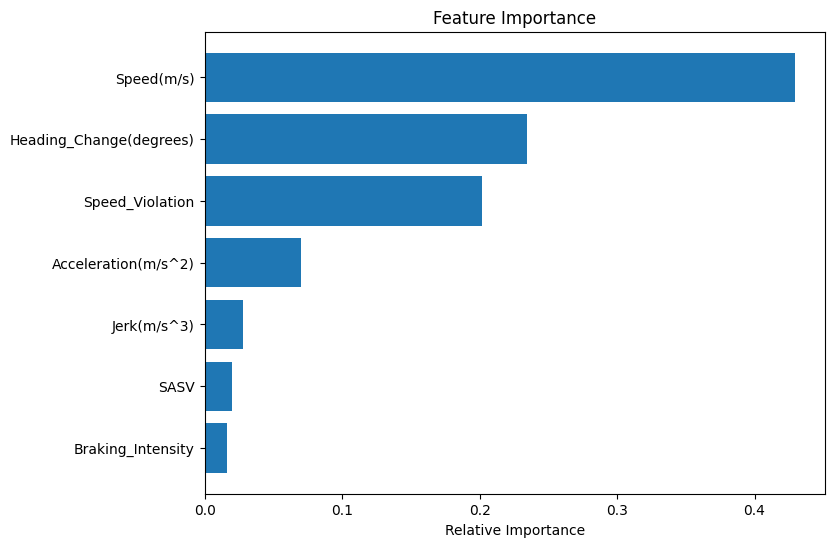

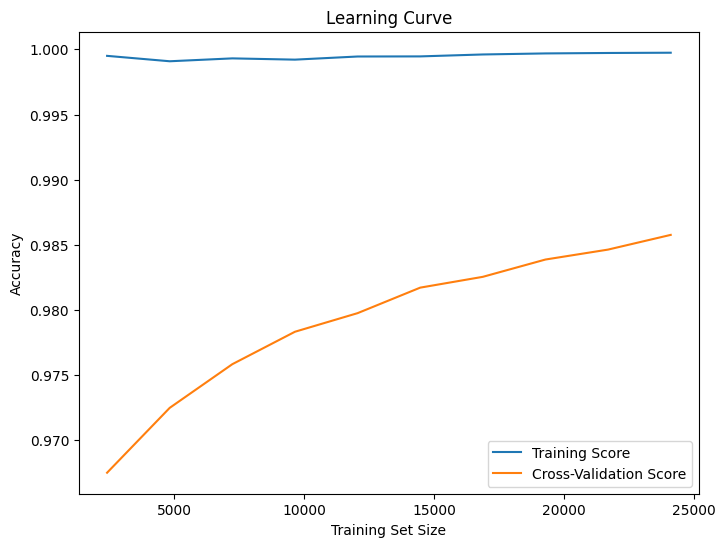

Cross-Validation Accuracy: 98.58% ± 0.15%


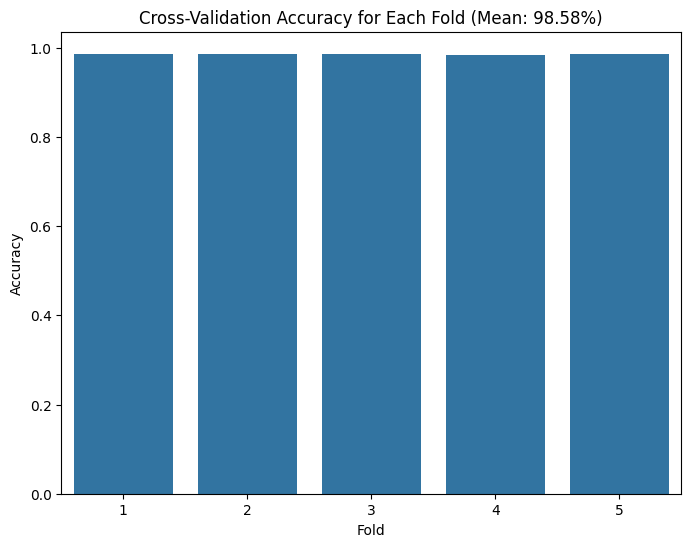

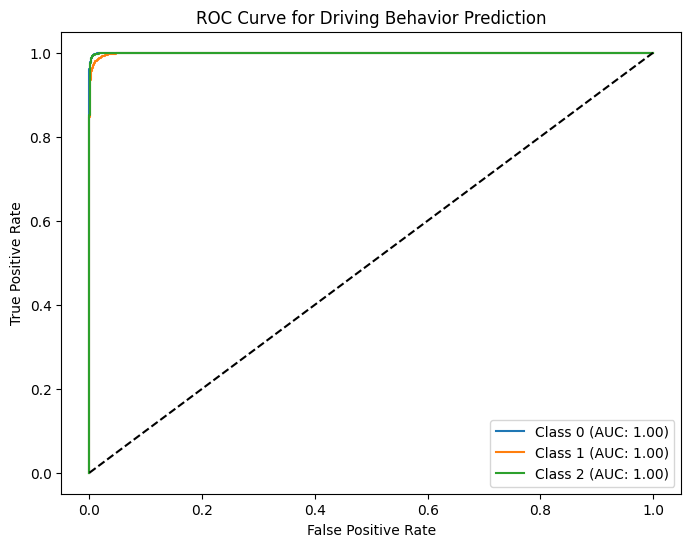

Model and Scaler saved successfully.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import pickle

# Set up paths for saving models and scalers
model_directory = '../models'
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Load the processed data
df = pd.read_csv('../data/processed_data.csv')

# Select Features and Labels (Ensuring all important features like SASV and Speed Violation are included)
X = df[['Speed(m/s)', 'Acceleration(m/s^2)', 'Heading_Change(degrees)', 'Jerk(m/s^3)', 
        'Braking_Intensity', 'SASV', 'Speed_Violation']]
y = df['Driving_Category'].map({'Risky': 0, 'Moderate': 1, 'Safe': 2})  # Convert categories to numeric

# Train-test split (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for future use
scaler_path = os.path.join(model_directory, 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

# RandomForestClassifier setup
rf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning using RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 150], 
    'max_depth': [10, 20, None],     
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],    
    'max_features': ['sqrt', 'log2', None]  
}

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=-1, random_state=42)
random_search.fit(X_train_scaled, y_train)

# Best model parameters after hyperparameter tuning
print("Best Hyperparameters: ", random_search.best_params_)

# Train the best RandomForest model
best_rf_model = random_search.best_estimator_

# Evaluate on the test set
y_pred = best_rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save the trained model
model_path = os.path.join(model_directory, 'driving_data_model.pkl')
with open(model_path, 'wb') as model_file:
    pickle.dump(best_rf_model, model_file)

# ---------- Performance Metrics and Visualizations ---------- #

# 1. Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Risky', 'Moderate', 'Safe']))

# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Risky', 'Moderate', 'Safe'], 
            yticklabels=['Risky', 'Moderate', 'Safe'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 3. Feature Importance
importances = best_rf_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order

plt.figure(figsize=(8, 6))
plt.title("Feature Importance")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# 4. Learning Curve
def plot_learning_curve(model, X_train, y_train, cv=5):
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=cv, n_jobs=-1, 
                                                            train_sizes=train_sizes)
    
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label='Training Score')
    plt.plot(train_sizes, test_mean, label='Cross-Validation Score')
    plt.title('Learning Curve')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_learning_curve(best_rf_model, X_train_scaled, y_train)

# 5. Cross-validation Score Plot
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_rf_model, X_train_scaled, y_train, cv=kf)
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)
print(f"Cross-Validation Accuracy: {cv_mean * 100:.2f}% ± {cv_std * 100:.2f}%")

# 6. Visualizing Cross-Validation Scores
plt.figure(figsize=(8,6))
sns.barplot(x=np.arange(1, 6), y=cv_scores)
plt.title(f'Cross-Validation Accuracy for Each Fold (Mean: {cv_mean * 100:.2f}%)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.show()

# 7. ROC Curves (Optional, but useful for classification problems)
y_prob = best_rf_model.predict_proba(X_test_scaled)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):  # For each class (Risky, Moderate, Safe)
    fpr[i], tpr[i], _ = roc_curve(y_test, y_prob[:, i], pos_label=i)
    roc_auc[i] = roc_auc_score(y_test == i, y_prob[:, i])

plt.figure(figsize=(8,6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC: {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Driving Behavior Prediction')
plt.legend(loc='best')
plt.show()

# ---------- Save Model and Scalability ---------- #
print("Model and Scaler saved successfully.")
